In [1]:
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import cv2 
import sys
import os
from sklearn.mixture import GaussianMixture
import seaborn as sns
from matplotlib.patches import Patch
import numpy as np
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import pickle
import pandas as pd
sys.path.append("../")
from src import *

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
rois = [os.path.splitext(f)[0][7:] for f in os.listdir("../data/ROIs/ground_truth_ROI/filled") if "filled" in f]

In [6]:
data = get_data_csv()
data = data[data["Group"] == "Melanoma"]
data["Coarse tumor stage"] = data["Float tumor stage"] > 0.5
rois = [os.path.splitext(f)[0][7:] for f in os.listdir("../data/ROIs/ground_truth_ROI/filled") if "filled" in f]
#data = data[data["file_path"].isin(rois)]

In [7]:
data = data[data["file_path"].isin(rois)]
data = data.reset_index()
data.drop([3, 5], inplace=True)

In [8]:
data

,index,Histo-ID,Run-ID,Collection data,Sex,Age,Type,Group,Dataset,Tumor Thickness [mm],...,Death caused by Melanoma,Therapy,Diagnosis Confirmed,Clinical Diagnosis,Skin Involvement,Death by CL,Collection year,Imaging year,Float tumor stage,Coarse tumor stage
0,190,B029,20974,10/14/2010,m,70,Superficial Spreading Melanoma,Melanoma,Melanoma,0.40,...,NaN,keine,NaN,NaN,NaN,NaN,2010,2020,0.25,False
1,201,B515,20985,9/24/2019,m,62,Superficial Spreading Melanoma,Melanoma,Melanoma,0.80,...,NaN,keine,NaN,NaN,NaN,NaN,2019,2020,0.25,False
2,204,B032,20992,10/14/2010,m,70,Superficial Spreading Melanoma,Melanoma,Melanoma,0.20,...,NaN,keine,NaN,NaN,NaN,NaN,2010,2020,0.25,False
4,207,B033,20998,10/14/2010,m,70,Superficial Spreading Melanoma,Melanoma,Melanoma,1.50,...,NaN,keine,NaN,NaN,NaN,NaN,2010,2020,0.50,False
6,211,B196,21010,12/11/2013,f,71,Superficial Spreading Melanoma,Melanoma,Melanoma,20.00,...,True,"Ipilimumab/Pembrolizumab (PR), Pembro (SD, PD)...",NaN,NaN,NaN,NaN,2013,2020,1.00,True
7,217,B497,21047,5/10/2019,f,64,Superficial Spreading Melanoma,Melanoma,Melanoma,3.10,...,NaN,keine,NaN,NaN,NaN,NaN,2019,2020,0.75,True
8,226,B104,21060,10/20/2011,f,44,Superficial Spreading Melanoma,Melanoma,Melanoma,2.80,...,NaN,interferon-alpha adjuvant,NaN,NaN,NaN,NaN,2011,2020,0.75,True
9,229,B462,21069,12/11/2018,f,78,Superficial Spreading Melanoma,Melanoma,Melanoma,2.25,...,NaN,keine,NaN,NaN,NaN,NaN,2018,2020,0.75,True
10,233,B279,21087,3/2/2017,m,91,Superficial Spreading Melanoma,Melanoma,Melanoma,20.00,...,True,keine,NaN,NaN,NaN,NaN,2017,2020,1.00,True
11,237,B217,21100,4/1/2014,m,77,Malignant Melanoma,Melanoma,Melanoma,12.50,...,NaN,keine,NaN,NaN,NaN,NaN,2014,2020,1.00,True


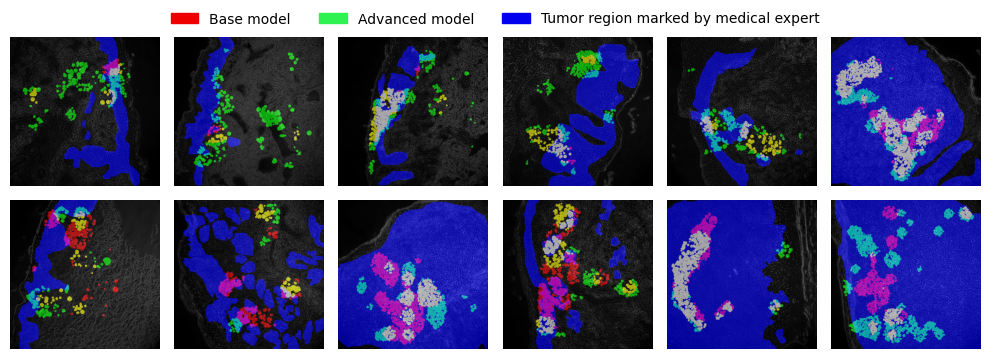

In [18]:
config_path = "/data_nfs/je30bery/melanoma_data/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
ne = NeighborEnricher(None, config=config)

mod = 6
f, axs = plt.subplots(2, mod, figsize=(10, 3.7))
base = "/data_nfs/"
data_path = os.path.join(base, "datasets/melc/melanoma/")
greens = list()
reds = list()

for d in range(len(data)):
    fov = data.iloc[d]["file_path"]
    segmented = os.path.join(base, "datasets/melc/melanoma/", "segmented", f'{fov}_cells.npy')
    try:
        with open(segmented, "rb") as openfile:
            seg_file = np.load(openfile)
    except Exception as e:
        print(e)
        print(d)
        continue
    
    binary = np.isin(seg_file, ne.get_roi_cells(fov, model="melanoma_vs_nevi_clf")[1:])
    red = cv2.resize((binary * 255).astype(np.uint8), (512, 512))

    binary = np.isin(seg_file, ne.get_roi_cells(fov, model="tumor_stage_clf")[1:])
    green = cv2.resize((binary * 255).astype(np.uint8), (512, 512))

    roi = cv2.imread(os.path.join(base, f"je30bery/melanoma_data/data/ROIs/ground_truth_ROI/filled/filled_{fov}.tif"), cv2.IMREAD_GRAYSCALE)
    roi = cv2.resize(roi, (512, 512))
    if d == 5:
        roi = (roi > 15).astype(np.uint8)
    else:
        roi = (roi > 0).astype(np.uint8)

    rgb = np.array([red, green, roi * 255], dtype=np.uint8).transpose((1, 2, 0))

    phase = cv2.imread([os.path.join(data_path, "processed", fov, f) for f in os.listdir(os.path.join(data_path, "processed", fov)) if "phase.tif" in f.lower()][0])
    phase = cv2.resize(phase, (512, 512))

    axs[d // mod, d % mod].imshow(cv2.addWeighted(phase, 0.4, rgb, 0.6, 0))
    axs[d // mod, d % mod].axis("off")#
    if d // mod == 0:
        axs[d // mod, d % mod].set_title("\n", fontsize=5)

palette = {"Base model": "#EE0000", "Advanced model": "#2EF250", "Tumor region marked by medical expert": "#0000EE"}

legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]

plt.figlegend(handles=legend_handles, loc="upper center", ncol=3, frameon=False)

plt.tight_layout()
plt.savefig("../result_plots/models_on_groundtruth.pdf")

In [24]:
data = get_data_csv()
data = data[data["Group"] == "Melanoma"]
data["Coarse tumor stage"] = data["Float tumor stage"] > 0.5
rois = [os.path.splitext(f)[0][7:] for f in os.listdir("../data/ROIs/ground_truth_ROI/filled") if "filled" in f]
#data = data[data["file_path"].isin(rois)]

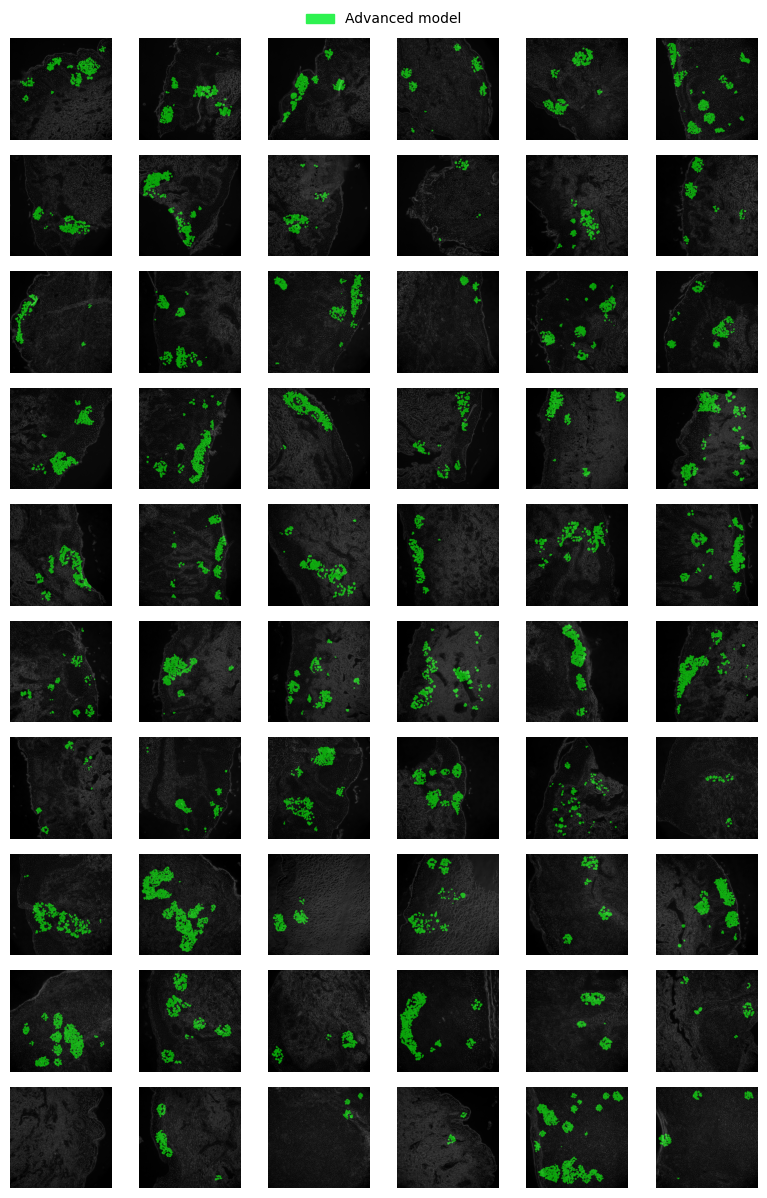

In [25]:
f, axs = plt.subplots(10, 6, figsize=(8, 12))
base = "/data_nfs/"
data_path = os.path.join(base, "datasets/melc/melanoma/")
greens = list()
reds = list()

for d in range(len(data)):
    fov = data.iloc[d]["file_path"]
    segmented = os.path.join(base, "datasets/melc/melanoma/", "segmented", f'{fov}_cells.npy')
    try:
        with open(segmented, "rb") as openfile:
            seg_file = np.load(openfile)
    except Exception as e:
        print(e)
        print(d)
        continue
    
    binary = np.isin(seg_file, ne.get_roi_cells(fov, model="melanoma_vs_nevi_clf")[1:])
    red = cv2.resize((binary * 255).astype(np.uint8), (512, 512))
    reds.append(red)

    binary = np.isin(seg_file, ne.get_roi_cells(fov, model="tumor_stage_clf")[1:])
    green = cv2.resize((binary * 255).astype(np.uint8), (512, 512))
    greens.append(green)
    
    rgb = np.array([np.zeros_like(green), green, np.zeros_like(green)], dtype=np.uint8).transpose((1, 2, 0))

    phase = cv2.imread([os.path.join(data_path, "processed", fov, f) for f in os.listdir(os.path.join(data_path, "processed", fov)) if "phase.tif" in f.lower()][0])
    phase = cv2.resize(phase, (512, 512))

    axs[d // 6, d % 6].imshow(cv2.addWeighted(phase, 0.4, rgb, 0.6, 0))
    axs[d // 6, d % 6].axis("off")#
    if d // 6 == 0:
        axs[d // 6, d % 6].set_title("\n", fontsize=5)

palette = {"Advanced model": "#2EF250"}

legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]

plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=False)

plt.tight_layout()
#plt.savefig("../result_plots/all_rois_both_models.pdf")

In [26]:
reds = np.concatenate(reds)
greens = np.concatenate(greens)

In [27]:
np.sum(reds > 0)

526731

In [28]:
np.sum(greens > 0)

728426

In [29]:
intersection = np.sum(np.logical_and(reds > 0, greens > 0))
union = np.sum(np.logical_or(reds > 0, greens > 0))
print(intersection/union)

0.2686016401826558
